# Molecular Modeling Software: Open Babel

- toc: false
- branch: master
- badges: true
- comments: false
- categories: [molecular modeling, scientific computing, grad school]

"Open Babel is a chemical toolbox designed to speak the many languages of chemical data. It's an open, collaborative project allowing anyone to search, convert, analyze, or store data from molecular modeling, chemistry, solid-state materials, biochemistry, or related areas."
* [Open Babel main page](http://openbabel.org/wiki/Main_Page)
* [Open Babel overview documentation](http://openbabel.org/docs/current/index.html)
* [Open Babel git repo](https://github.com/openbabel/openbabel)

Open Babel is written in C++ and can be interacted with via the command line or C++ scripts, but I want to focus on the Python interface for Open Babel, `pybel`
* [Pybel documentation](https://openbabel.org/docs/dev/UseTheLibrary/Python_Pybel.html)
* [Pybel in the repo](https://github.com/openbabel/openbabel/blob/master/scripts/python/openbabel/pybel.py)

Open Babel and pybel are available [on pip](https://pypi.org/project/openbabel/) and [conda](https://anaconda.org/openbabel/openbabel).

There seems to be an [interesting history](https://openbabel.org/wiki/Frequently_Asked_Questions) in which there was first Babel, open-sourced by others into OpenBabel, but shares some history with OELib/OEChem from OpenEye.

Given I'm Python-centric, I like to dabble with pybel to interface with openbabel, and see where openbabel functionality could be useful (maybe from a molecular modelling perspective).

In [1]:
import openbabel
import pybel

For starters, pybel provides functionality to read smiles strings, with some convenient 2D visualization within Jupyter. This is propane ($C_3H_8$).

Going further, openbabel [supports a wide range of fileformats](http://openbabel.org/docs/current/FileFormats/Overview.html)

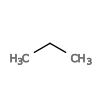

In [2]:
molecule = pybel.readstring("smi", 'CCC')
molecule

In [4]:
type(molecule)

pybel.Molecule

Within this `pybel.Molecule` object, we can access various other data. 
Notably, we can access the underlying `openbabel.OBMol` object as defined in the C source code.
This is handled using the SWIG package, and this is our route to utilizing
openbabel functionality within python

In [3]:
molecule.OBMol

<openbabel.OBMol; proxy of <Swig Object of type 'OpenBabel::OBMol *' at 0x10e33e840> >

The `openbabel.OBMol` object is immense, so I refer readers to [the API](http://openbabel.org/dev-api/classOpenBabel_1_1OBMol.shtml) for an exhaustive list of getters, setters, and other functions relevant to molecular modelling and cheminformatics.

Openbabel ships with a variety of iterator objects to loop through various properties of `openbabel.OBMol` objects.
Not as pythonic as trying to generators or enumeration, but it still works

In [5]:
for atom in openbabel.OBMolAtomIter(molecule.OBMol):
    print(atom.GetIndex(),atom.GetType(), atom.GetAtomicNum())

0 C3 6
1 C3 6
2 C3 6


Since we created `pybel.Molecule` out of a SMILES string, the hydrogens were implicit and ignored.
To fully enumerate this compound, we can add hydrogens

In [7]:
for atom in openbabel.OBMolAtomIter(molecule.OBMol):
    molecule.OBMol.AddHydrogens(atom)

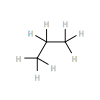

In [8]:
molecule

In [9]:
for atom in openbabel.OBMolAtomIter(molecule.OBMol):
    print("{:<4}{:<4}{:<4}".format(atom.GetIndex(), atom.GetType(), atom.GetAtomicNum()))


0   C3  6   
1   C3  6   
2   C3  6   
3   H   1   
4   H   1   
5   H   1   
6   H   1   
7   H   1   
8   H   1   
9   H   1   
10  H   1   


We can also iterate through the bonds in our `openbabel.Molecule` object, and even get an idea for the equilibrium bond length

In [10]:
for bond in openbabel.OBMolBondIter(molecule.OBMol):
    print("{:<5}{:<5}{:<5}".format(
        bond.GetBeginAtom().GetIndex(), bond.GetEndAtom().GetIndex(), 
        bond.GetEquibLength()))

0    1    1.52 
1    2    1.52 
0    3    1.07 
0    4    1.07 
0    5    1.07 
1    6    1.07 
1    7    1.07 
2    8    1.07 
2    9    1.07 
2    10   1.07 


The angles

In [11]:
molecule.OBMol.FindAngles()
for angle in openbabel.OBMolAngleIter(molecule.OBMol):
    print(angle)

(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 3, 4)
(0, 3, 5)
(0, 4, 5)
(1, 0, 2)
(1, 0, 6)
(1, 0, 7)
(1, 2, 6)
(1, 2, 7)
(1, 6, 7)
(2, 1, 8)
(2, 1, 9)
(2, 1, 10)
(2, 8, 9)
(2, 8, 10)
(2, 9, 10)


And the torsions (proper dihdrals, not improper)

In [12]:
molecule.OBMol.FindTorsions()
for dih in openbabel.OBMolTorsionIter(molecule.OBMol):
    print(dih)

(3, 0, 1, 2)
(3, 0, 1, 6)
(3, 0, 1, 7)
(4, 0, 1, 2)
(4, 0, 1, 6)
(4, 0, 1, 7)
(5, 0, 1, 2)
(5, 0, 1, 6)
(5, 0, 1, 7)
(0, 1, 2, 8)
(0, 1, 2, 9)
(0, 1, 2, 10)
(6, 1, 2, 8)
(6, 1, 2, 9)
(6, 1, 2, 10)
(7, 1, 2, 8)
(7, 1, 2, 9)
(7, 1, 2, 10)


## SMARTS matching within openbabel
Every `openbabel.OBAtom` object has the function [MatchesSMARTS](http://openbabel.org/dev-api/classOpenBabel_1_1OBAtom.shtml#abfdefac42d3c895920f1f715f0d710a5).

Without referring to much to my earlier Foyer post, SMARTS matching helps identify atoms within a system that fit a particular SMARTS pattern (chemistry and bonding)

This next section will do some primitive atomtyping via SMARTS matching. 

To start, we'll create a dictionary that relates atomtypes to their SMARTS definition (a boiled-down version of the Foyer FFXML). 

In [13]:
smarts_definitions = {
    'internal C':'[C;X4]([C])([C])([H])[H]',
    'external C':'[C;X4]([C])([H])([H])[H]',
    'external H':'[H][C;X4]',
    'internal H':'[H]([C;X4]([C])([C]))',
}

Next, we will iterate through all of our atoms. For each atom, we will iterate through each of our SMARTS definitions to see if there is a match

In [14]:
for atom in openbabel.OBMolAtomIter(molecule.OBMol):
    matched = False
    for label, smarts in smarts_definitions.items():
        if atom.MatchesSMARTS(smarts):
            print("Atom {} is {}".format(atom.GetIndex(), label))
            matched = True
    if not matched:
        print("Atom {} is unmatched".format(atom.GetIndex()))

Atom 0 is external C
Atom 1 is internal C
Atom 2 is external C
Atom 3 is external H
Atom 4 is external H
Atom 5 is external H
Atom 6 is external H
Atom 6 is internal H
Atom 7 is external H
Atom 7 is internal H
Atom 8 is external H
Atom 9 is external H
Atom 10 is external H


It's also worth noting that the [SMARTS definitions in openbabel](https://openbabel.org/wiki/SMARTS) are slightly different from SMARTS in Foyer. This isn't so surprising since scientists are always devising their own takes on SMILES and SMARTS nowadays. 
Some other key differences:
* Foyer can utilizes labels (when matching SMARTS patterns, we can also leverage the atoms for which we already know the atom type). The code above doesn't apply labels, nor would the SMARTS matching in openbabel know what to do with the labels. In this regard, it's helpful that Foyer has its own SMARTS matching engine
* Foyer utilizes blacklists and whitelists to help identify multiple atom types while resolving to a singular atom type.

## Force fields 
Openbabel has some support for [molecular mechanics force fields](https://github.com/openbabel/openbabel/tree/master/src/forcefields) (GAFF, UFF, MMFF94, MM2, ghemical).

Within Openbabel, these basic FFs can parametrize systems and also compute forces/energies.
Some functional forms appear to include harmonic bonds, harmonic angles, periodic torsions, RB torsions, LJ nonbond interactions, harmonic impropers, and Coulombic interactions.
These various computes are defined as classes within each FF, so it's a little different from OpenMM where there are broadly classes of different force objects for different FFs to utilizes when studying a system. 
For each force class's compute method, you pass the relevant parameters and measurables, and out pops the gradient or energy.

From these force fields, you can generate conformers, perform energy mimization, and even run molecular dynamics (with constraints and cutoffs)

## Summary
Open babel is an extensive molecular modelling, cheminformatics, and bioinformatics package, and I'm sure many computational chemists/biologists would find something useful within this library. As the name "Babel" suggests, it's related to all the many various languages that split from one, original language. The Open babel library has a lot of functionality and API that a C++ or Python (or CLI) developer could utilize in their own work.